# CivicScape Model Data Practices

## Introduction

This Python notebook introduces you to some of the metrics that
CivicScape uses to track the performance of the CrimeScape tool. 

This text will guide you through the various calculations
for our model metrics, including helpful descriptions of why certain
statistics are calculated and what they mean. We also compare these model metrics to current police department practices.

If you want to dig into how everything is being calculated, there is
a supporting python document in the same folder as this notebook called 
notebook_support.py that contains all the functions with the prefix '`notebook_support.`' below.

**To begin**, please edit the strings in the module below so that they
point to the correct data files for use. Then, run all the modules.

In [179]:
# Use the following string to tell this notebook where the CivicScape data are located
risk_path = "../data/risk_assessments.csv"

# Use the following string to tell this notebook where the historical data are located
hist_path = "../data/historical_grouped_3_year.csv"

Great! Now, run the notebook using Cell -> Run All above. This may take a minute or two for processing.

In [180]:
import pandas as pd
import os
import numpy as np
import sklearn as sk
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
import notebook_support
reload(notebook_support)
from IPython.display import Image

The notebook will pull in the data you specified above in the module below. It will also do a quick
check to make sure that the columns in the data you're using match what the code expects to see.

In [ ]:
risk_assessment = pd.read_csv(risk_path)
historical = pd.read_csv(hist_path)

# This code checks to make sure the files have the correct columns
notebook_support.data_check(risk_assessment, historical)

CivicScape risk scores are forward-looking, specifically
72 hours from the current time by the hour. To enable the tool to compute three-day risk scores, we look at past crimes to understand the circumstances around them, allowing us to understand 
where and when they might occur.

Before we present those risk scores, however, we go through a 
set of tests to understand whether the model will give us good
results. What consitutes 'good' is a complicated question: we go through
to few possible ways to define that here.

First, we test the tool's ability to correctly assess crime risk for time periods where
we know the correct answer. 

To do this, we first split historical data into two sets: a training set 
and test set. While we know when and where crimes have actually occurred 
in both sets, the timeframe of the test set is after the training set. 
This allows us to use the training set to build a model, then to use 
that model to predict whether crimes will occur during the test set timeframe.
This will give us a view as to how the model performs "out of sample".

The risk scores file represents data from that testing data set. 
It should already contain records of how many crimes
actually occurred in the hour for each hour in each census
tract. 

This next module tells you what the testing period is for the data you've 
imported. It will also do a few quick calculations to get the data ready for 
use. 

In [182]:
risk, hist = notebook_support.data_prep(risk_assessment, historical)


Data prep done!
This file contains risk_assessments for the test date range 2014-10-24 00:00:00 through 2015-05-28 00:00:00.


### Custom Date Range, Hours, or Days of the Week

If you'd like to select particular hours, days of the week, or a date range, please enter them below. *Even if you don't select custom dates, please make sure to run the following module so that the rest of the notebook functions correctly.*

In [183]:
hours = () # Enter the hour range to include on a 24-hour clock, e.g. (3, 15) returns 3AM-3PM
days = [] # Enter each day to include as a letter i.e. ['M', 'T', 'W', 'R', 'F', 'Sa', 'Su']
date_range = () # Enter the dates as YYYY-MM-DD, e.g. ('2014-10-24', '2015-05-28')
risk_keep, risk, hist = notebook_support.historical_prep(risk_assessment, historical)
risk_assessment, historical = notebook_support.constrict_times(risk_assessment, hist, hours, days, date_range)


Looks like your historical dataset doesn't have days, so we'll look at months instead.

The period from 2014-10-01 00:00:00 to 2014-10-24 00:00:00 will be left off the dataset because data are missing.

The period from 2015-05-28 00:00:00 to 2015-09-01 00:00:00 will be left off the dataset because data are missing.

The final overlapping period for analysis is: 2014-10-24 00:00:00 through 2015-05-28 00:00:00


## Understanding Model Performance on Test Data

In everyday language, we often talk about risk scores being *accurate*. But, in most machine learning cases, accuracy alone isn't helpful. In the context of our research question, accuracy can be defined as:

- **Accuracy**: percent of the time that the model correctly predicts whether a crime does or does not occur.

In the case of our dataset, there are very few hours for each tract that have crimes: only about 6 out of every 10,000, or .058% of the dataset, for example, for one jurisdiction we have studied. So, even if our model predicted that *every hour for every tract in the city* was a non-crime hour no matter what, 100% of the time, we'd have an accuracy of 99.95% -- which is super high! But for a tool to deploy officers into the field, this would be completely useless.

Instead, we look at a confusion matrix to get an idea of different ways in which our model might perform well and not well. A confusion matrix has four metrics that tease apart Accuracy in more detail. They are:

- **True Postitive Rate**: when a crime does happen, the percent of the time the model correctly predicts it.
- **True Negative Rate**: when a crime doesn't happen, percent of the time the model correctly predicts none happen.
- **False Positive Rate**: when a crime doesn't happen, percent of the time the model predicts one would.
- **False Negative Rate**: when a crime does happen, precent of the time the model misses it.

We put them into a diagram like the one below for ease of reading:

<img src="visuals/confusion_matrix.png" height="300" width="300" align="left">

**Source**: http://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix/

In every application, these metrics are associated with different costs. For example, to predict when a house is at high risk for lead poisoning, it may not be that costly to have a False Positive (an inspector goes to check out the house for no reason), but it's very costly if we have a False Negative (a child may wind up with lead poisoning). In that instance, we would want to have a high *True Positive Rate* (which is the opposite of False Negatives) even if it means sacrificing performance of our *True Negative Rate* (which is the opposite of False Positives), because the latter is not as costly.

In the case of CivicScape, we also consider False Negatives costlier than False Positives. This is the difference between potentially preventing a crime or having a couple of extra officers unnecessarily, especially when most areas of a jurisdiction have some police presence. Therefore, what's most important to us is improving our True Positive rate and reducing our False Negative rate, while maintaining a reasonable False Positive Rate. Specifically, we aim to maintain a false positive rate that falls well below what the current deployment resourcing model requires of the department. We will get into how we calculate that more later in this notebook. Ultimately, though, it is ideal to have a High True Positive and True Negative Rates with low False Positive and False Negative Rates.

Before we can calculate these metrics for the CrimeScape tool, there's a really important question that needs to be answered. You see, when we run a model, our outputs generally look something like this: 

In [184]:
out = pd.DataFrame(risk_assessment.iloc[:2][['census_tra','dt', 'risk_assessment']])
out.columns = ['Census Tract', 'Date', 'Probability of Crime']
out

Census Tract       Date  Probability of Crime
0        671500 2014-10-24              0.742411
1        671600 2014-10-24              0.685709

Note that the model doesn't say "a crime will occur here at this time." Instead, we obtain risk scores for a given time and place. This makes sense, but we need to translate a risk score into a decision so that it looks like this:

In [185]:
out = pd.DataFrame(risk_assessment.iloc[:2][['census_tra','dt']])
out.columns = ['Census Tract', 'Date-Time']
out['Risk_assessment'] = ['Crime', 'No Crime']
out

Census Tract  Date-Time Risk_assessment
0        671500 2014-10-24           Crime
1        671600 2014-10-24        No Crime

To translate into this Crime/No Crime or Yes/No form, we have to make a decision about a *threshold* at which we want to say our probability amounts to an assessment that 'yes, a crime is likely to occur.' The risk score won't make that decision for us. Should a 75% probability be considered an assessment of 'yes'? A 90% probability? 

Luckily, there is a science of going about doing this, and it begins with a **Receiver Operating Characteristic, or ROC Curve**.

### Finding a Reasonable Threshold for Risk Assessment

A Receiver Operating Characteristics Curve, or ROC Curve, plots the True Positive Rate against the False Positive Rate for all possible probability thresholds. Below is the table that is the basis for the ROC curve:

In [186]:
fpr, tpr, thresholds = metrics.roc_curve(risk_assessment.crime_count, risk_assessment.risk_assessment, pos_label=1)
roc_auc = metrics.roc_auc_score(risk_assessment.crime_count,risk_assessment.risk_assessment)
out = pd.concat([pd.Series(thresholds), pd.Series(tpr), pd.Series(fpr)], axis=1)
out.columns = ['Probability Threshold','True Positive Rate', 'False Positive Rate']
out.head()

Probability Threshold  True Positive Rate  False Positive Rate
0               1.942838            0.000000         0.000000e+00
1               0.942838            0.000000         2.195747e-07
2               0.920018            0.000000         4.369536e-05
3               0.920015            0.000377         4.369536e-05
4               0.910558            0.000377         1.403082e-04

We convert this into a plot to understand how the True Positive Rate (TPR) and False Positive Rate (FPR) relate to each other. Note that there is a blue dotted line: this line represents a model that is equally likely to have a false positive and a true negative for each threshold. In general, we want to have an orange line--representing the relationship between the TPR and FPR--that bows upward away from the blue line, as this model is more likely to have a True Positive result than a False Positive result for the thresholds mapped. 

An easy way to summarize this is the Area-Under-the-Curve, or AUC, metric. If the ROC AUC is larger than 0.5, it means the model tends to correctly predict crimes more often than it incorrectly predicts crime. That score can actually serve as a means for comparing different models, since it also gives a magnitude of how often the model has true positives vs. false positives. 

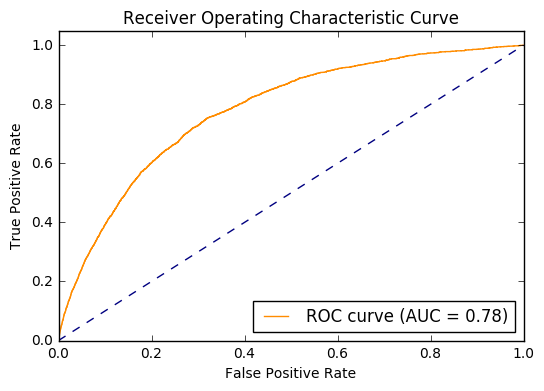

In [187]:
notebook_support.plot_roc(fpr, tpr, thresholds, roc_auc)

Alternatively, we can also chart both the FPR and TPR against the Thresholds directly, as we do below:

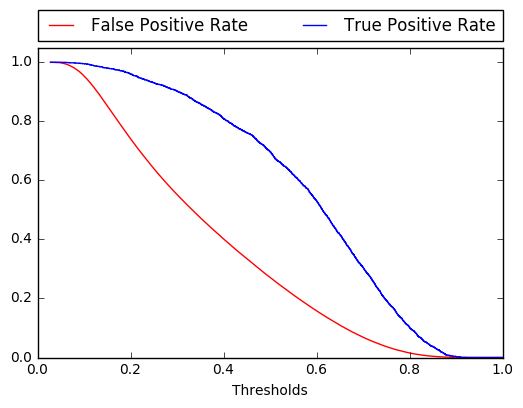

In [188]:
notebook_support.plot_fpr_tpr(fpr, tpr, thresholds)

In general, we want a threshold that **maximizes the True Positive Rate** while also **minimizing the False Positive Rate**. That can be calculated mathematically, and we do that for you here:

In [189]:
notebook_support.optimal_threshold(thresholds, fpr, tpr)


The optimal threshold for your data is: 0.46.



You can set the threshold to use for the rest of this notebook in the module below. We have it set to 0.46 as a placeholder right now; but that might not be optimal for your data. You can put in the optimal threshold that the system gave you above, or you can enter in something else that seems reasonable to you.

**Change the threshold below as you see fit, then re-run the cells below using Cell -> Run All Below**:

In [190]:
threshold = .46

Below, we have calculated the confusion matrix for the risk assessments you loaded and the threshold you selected. As a reminder, here are the definitions we gave above:

- **Accuracy**: percent of the time that the model correctly predicts whether a crime occurs.
- **True Postitive Rate**: when a crime does happen, the percent of the time the model correctly predicts it.
- **True Negative Rate**: when a crime doesn't happen, percent of the time the model correctly predicts none happen.
- **False Positive Rate**: when a crime doesn't happen, precent of the time the model predicts one would.
- **False Negative Rate**: when a crime does happen, percent of the time the model misses it.

<img src="visuals/confusion_matrix.png" height="300" width="300" align="left">  

Here is the Confusion Matrix for the risk assessments you loaded into this notebook:

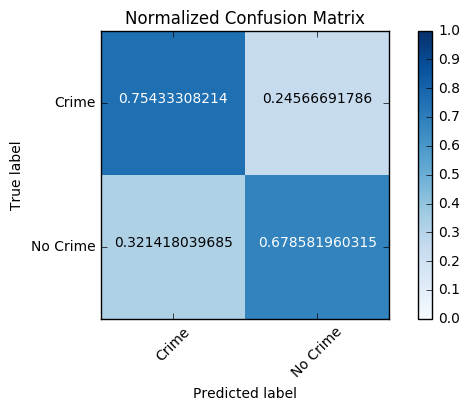

In [191]:
# This creates a binary term for whether a risk assessment is above or below the threshold
risk_assessment['risk_binary'] = np.where(risk_assessment['risk_assessment'] >= threshold, 1, 0)
# This calculates the confusion matrix
notebook_support.confusion_matrix(risk_assessment)

And with the below code, you can calculate those same statistics, compared to the accuracy for this model, in a table:

In [ ]:
notebook_support.metrics_table(risk_assessment)

By themselves, these statistics and metrics tell us a lot about the model. Even so, we need to compare how CivicScape assesses with risk of crime in relation to a meaningful baseline.  

## Finding a Baseline for Comparison: COMPSTAT

While there are a few other data-driven systems that also do assess the risk of crime for police departments, most cities in the US still rely on a system that is broadly refered to as CompSTAT: a data-driven policing deployment approach. Different approaches exist, but often, CompSTAT uses historical crime count averages to anticipate high-crime areas for a given beat assignment. 

This seems like a helpful baseline for us. Since many police departments use something similar, it will help us understand how the additional features we've added--plus the algorithms used--can improve upon existing systems. So, we use *three year historical averages* for tract/day combinations and use these to establish a baseline for comparison against the same test data that we compared our model to above.

First, we check to see whether the historical data you loaded at the beginning of the notebook contains sufficient data to run the analysis (and, if so, which period it can run the analysis on).

In [193]:
pred_keep, risk_assessment, historical = notebook_support.historical_prep(risk_assessment, historical)


Looks like your historical dataset doesn't have days, so we'll look at months instead.

The period from 2014-10-24 00:00:00 to 2014-11-01 00:00:00 will be left off the dataset because data are missing.

The period from 2015-05-28 00:00:00 to 2015-09-01 00:00:00 will be left off the dataset because data are missing.

The final overlapping period for analysis is: 2014-11-01 00:00:00 through 2015-05-28 00:00:00


### Comparison for Top Tracts by Volume of Crimes Predicted

One way that we can compare our model to the COMPSTAT model is to look at, for the areas of the city with the highest crime (or, the tracts that should be a priority for us), are we predicting anything different? 

To answer that question we have two charts below. The first compares the number of crimes predicted by tract, cumulatively as we add more and more low priority tracts. That is to say, on the left of the chart, we're looking at the difference between the two model predictions in terms of number of crimes predicted for the top tracts; as we head left, we see the difference as we add more and more less priority tracts into the mix. In general, we tend to see our model performing *most differently* in the middle portions of the graph. 

The second chart shows the actual distance between the two lines in the first chart. 

In [194]:
ACT_CRIMES = ['crime_count']
RISK_CRIMES = ['risk_assessment']
HIST_CRIMES = ['crime_count_historical']

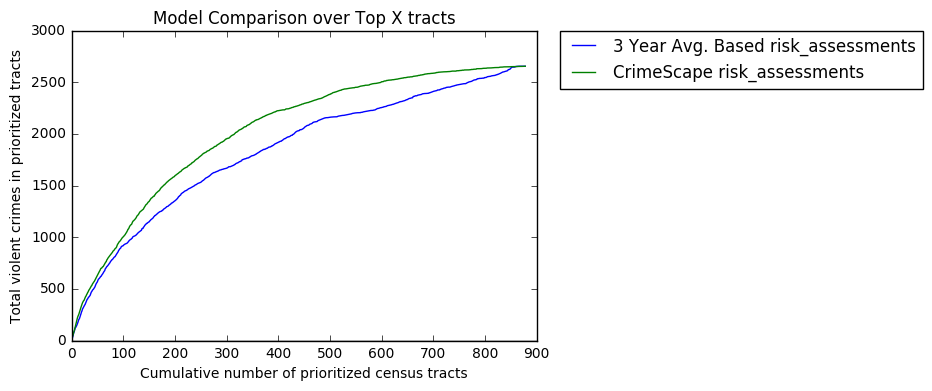

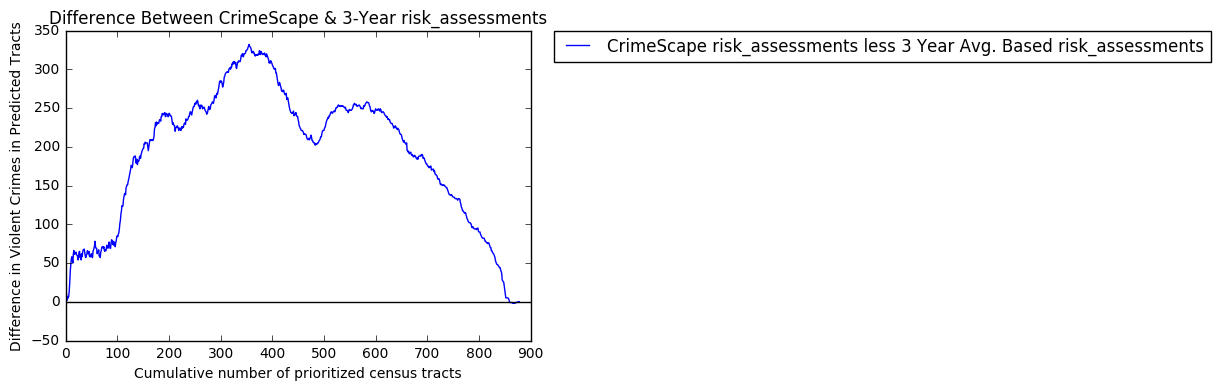

In [195]:
hist_merged, pred_merged, final = notebook_support.get_paper_comparisons(risk_keep, risk_assessment, historical)

### Confusion Matrix Comparison

We can also run the COMPSTAT style predictions through similar metrics as we did for the CivicScape model above. 

#### The ROC Curve for COMPSTAT Approach

First, like above, we run the ROC curve in order get a solid prediction threshold. 

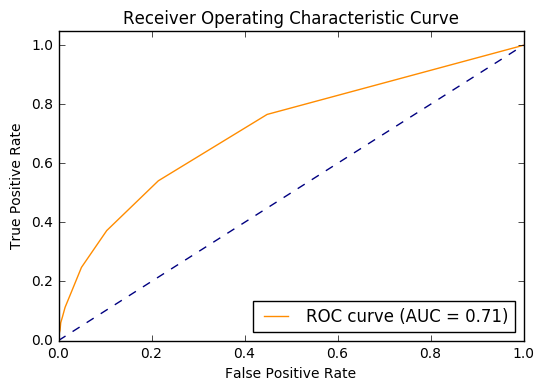

In [196]:
# Convert crime_count into a binary for whether a crime occurred
hist_merged['crime_count'] = np.where(hist_merged.crime_count >= 1, 1, 0)
# Use the historical three year average
hist_merged['risk_assessment'] = hist_merged.crime_count_historical/3
# Run ROC metrics
h_fpr, h_tpr, h_thresholds = metrics.roc_curve(hist_merged.crime_count, hist_merged.risk_assessment, pos_label=1)
h_roc_auc = metrics.roc_auc_score(hist_merged.crime_count, hist_merged.risk_assessment)
notebook_support.plot_roc(h_fpr, h_tpr, h_thresholds, h_roc_auc)

When we run the ROC curve against Chicago data, we find that the curve is poorly formed; this is because most of the tracts have 1 or 0 crimes for every hour for the past three years. Therefore, there are only really four thresholds that matter: 1.0, .66, .33, and 0.0 (though you'll notice a few have more than an average of one crime). It's thus not really worth calculating the optimal threshold.

We encourage you to try multiples of .33 using the module below and notice how it alters the confusion matrix. Compare this to the confusion matrix from the CivicScape model; we repeat the same confusion matrix we calculated above here for convenience. 

Before we get into those, a quick refresher on confusion matrices:

<img src="visuals/confusion_matrix.png" height="300" width="300" align="left">

**Source**: http://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix/

- **True Postitive Rate**: when a crime does happen, the percent of the time the model correctly predicts it. If this is higher, it means that the model is doing a better job anticipating crime.
- **True Negative Rate**: when a crime doesn't happen, percent of the time the model correctly predicts none happen. If this is higher, it means the model is doing a better job of anticipating when there isn't crime.
- **False Positive Rate**: when a crime doesn't happen, precent of the time the model predicts one would. If this is higher, it means that the model is more incorrect when it predicts a crime will occur.
- **False Negative Rate**: when a crime does happen, percent of the time the model misses it. If this is higher, it means that the model is missing more crimes.

In [197]:
hist_threshold = .66

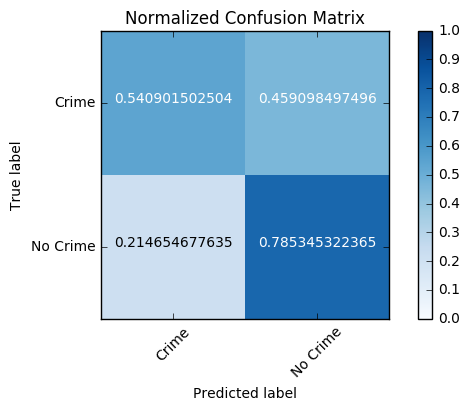

In [198]:
hist_merged['risk_binary'] = np.where(hist_merged.risk_assessment >= hist_threshold, 1, 0)
notebook_support.confusion_matrix(hist_merged)

And below is the confusion matrix for the CivicScape model using the threshold you defined earlier:

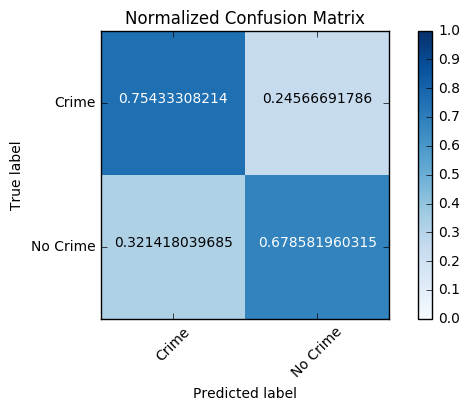

In [199]:
notebook_support.confusion_matrix(risk_assessment)

A more direct comparison of metrics can also be helpful. Below you can replicate the above figures in a table for the COMPSTAT style model:

In [ ]:
notebook_support.metrics_table(hist_merged)

And those same metrics from the CivicScape model:

In [ ]:
notebook_support.metrics_table(risk_assessment)

## Model Performance : 

CivicScape is committed to transparency in the data and algorithms that the CivicScape tool uses. This notebook outlines a number of ways we internally evaluate and think about the tool's performance, including: 

* Accuracy
* True Positive Rate
* False Positive Rate
* True Negative Rate
* False Negative Rate
* Comparison to CompStat, a useful baseline 

But there are many more evaluation metrics to consider and explore. We encourage you to check out the full extent of our evaluation methods in our Training_and_Testing codebase on our Github page. 

